Worked with:

- Trevor Mathisen
- Viet Nguyen

# Redo MLR HW with Boston dataset

In [2]:
from pandas import read_csv, DataFrame, Series
from pandas.plotting import scatter_matrix
from numpy import set_printoptions, argmax, isnan, nan, mean, random
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import tensorflow as tf
import numpy as np
import pandas as pd
print(tf.__version__)

2025-05-01 10:44:18.154325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 10:44:18.154833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 10:44:18.156889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 10:44:18.161042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746121458.168456  111834 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746121458.17

2.19.0


In [3]:
filename = 'boston.csv'
data = read_csv(filename)
set_printoptions(precision=3)
data = data.drop('index', axis=1)
print(data.head(5))
print(data.isnull().sum())
print(data.shape)
# Display unique values in each column
for col in data.columns:
    unique_values = data[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64
(506, 14)
Unique values in 'crim': [6.320e-03 2.731e-02 2.729e-02 3.237e-02 6.905e-02 2.985e-02 8.829e-02
 1.446e-01 2.112e-01 1.700e-01 2.249e-01 1.175e-01 9.378e-02 6.298e-

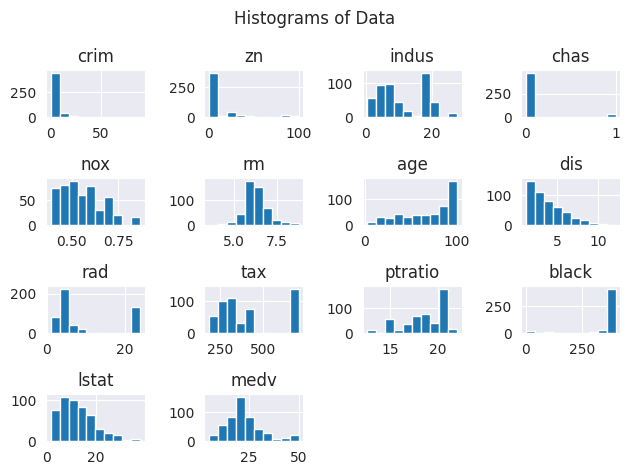

In [4]:
data.hist()
plt.suptitle(f"Histograms of Data")
plt.tight_layout()
plt.show()

In [5]:
features_to_standardize = ['rm', 'ptratio', 'dis', 'nox', 'tax', 'lstat']
features_to_normalize = ['crim', 'zn', 'indus', 'age', 'rad', 'black']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_to_standardize),
        ('norm', Normalizer(), features_to_normalize)
    ],
    remainder='passthrough'
)

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])
X = data.drop('medv', axis=1)
y = data['medv']
X_processed = preprocessing_pipeline.fit_transform(X)

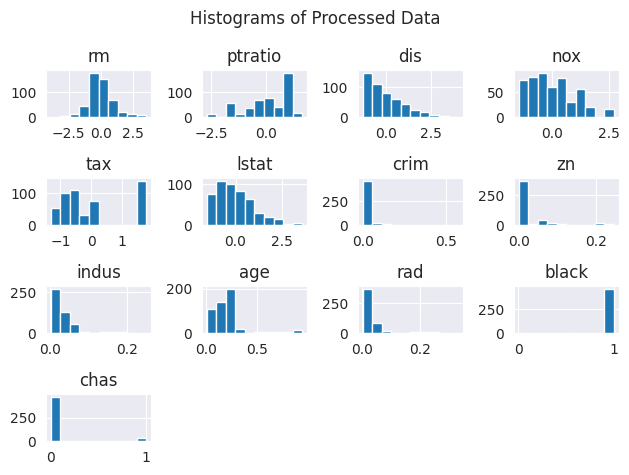

In [6]:
all_features = features_to_standardize + features_to_normalize + ['chas']

# Convert X_processed back to a DataFrame
X_processed = DataFrame(X_processed, columns=all_features)
X_processed.hist()
plt.suptitle("Histograms of Processed Data")
plt.tight_layout()
plt.show()

               rm   ptratio       dis       nox       tax     lstat      crim  \
rm       1.000000 -0.355501  0.205246 -0.302188 -0.292048 -0.613808 -0.167682   
ptratio -0.355501  1.000000 -0.232471  0.188933  0.460853  0.374044  0.239932   
dis      0.205246 -0.232471  1.000000 -0.769230 -0.534432 -0.496996 -0.301191   
nox     -0.302188  0.188933 -0.769230  1.000000  0.668023  0.590879  0.329051   
tax     -0.292048  0.460853 -0.534432  0.668023  1.000000  0.543993  0.476945   
lstat   -0.613808  0.374044 -0.496996  0.590879  0.543993  1.000000  0.372586   
crim    -0.167682  0.239932 -0.301191  0.329051  0.476945  0.372586  1.000000   
zn       0.310664 -0.392270  0.669000 -0.518360 -0.314757 -0.412822 -0.160441   
indus   -0.236454  0.297331 -0.498208  0.578670  0.623161  0.504321  0.636268   
age     -0.167547  0.252975 -0.502044  0.556711  0.535171  0.508832  0.648392   
rad     -0.138524  0.346488 -0.373426  0.455850  0.678546  0.428482  0.697182   
black    0.077473 -0.190044 

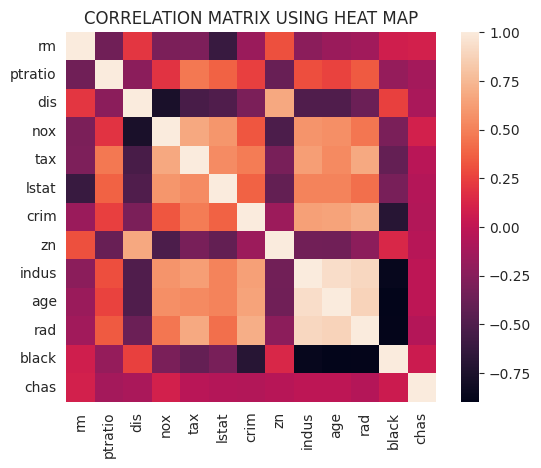

<Figure size 640x480 with 0 Axes>

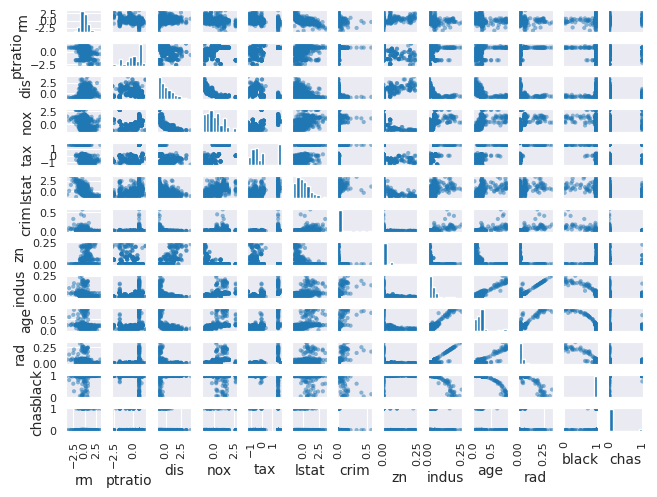

In [7]:
plt.figure() # new plot
#plt.tight_layout()
corMat = X_processed.corr(method='pearson')
print(corMat)
## plot correlation matrix as a heat map
sns.heatmap(corMat, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title(f"CORRELATION MATRIX USING HEAT MAP")
plt.show()

## scatter plot of all data
plt.figure()
# # The output overlaps itself, resize it to display better (w padding)
scatter_matrix(X_processed)
plt.tight_layout(pad=0.1)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

range(1, 14)
Num Features: 1
Selected Features: [False False False False False False False False  True False False False
 False]
Feature Ranking: [ 4 11 10 12 13  6  3  7  1  8  2  9  5]
Num Features: 2
Selected Features: [False False False False False False False False  True False  True False
 False]
Feature Ranking: [ 3 10  9 11 12  5  2  6  1  7  1  8  4]
Num Features: 3
Selected Features: [False False False False False False  True False  True False  True False
 False]
Feature Ranking: [ 2  9  8 10 11  4  1  5  1  6  1  7  3]
Num Features: 4
Selected Features: [ True False False False False False  True False  True False  True False
 False]
Feature Ranking: [ 1  8  7  9 10  3  1  4  1  5  1  6  2]
Num Features: 5
Selected Features: [ True False False False False False  True False  True False  True False
  True]
Feature Ranking: [1 7 6 8 9 2 1 3 1 4 1 5 1]
Num Features: 6
Selected Features: [ True False False False False  True  True False  True False  True False
  True]
Feature Rankin

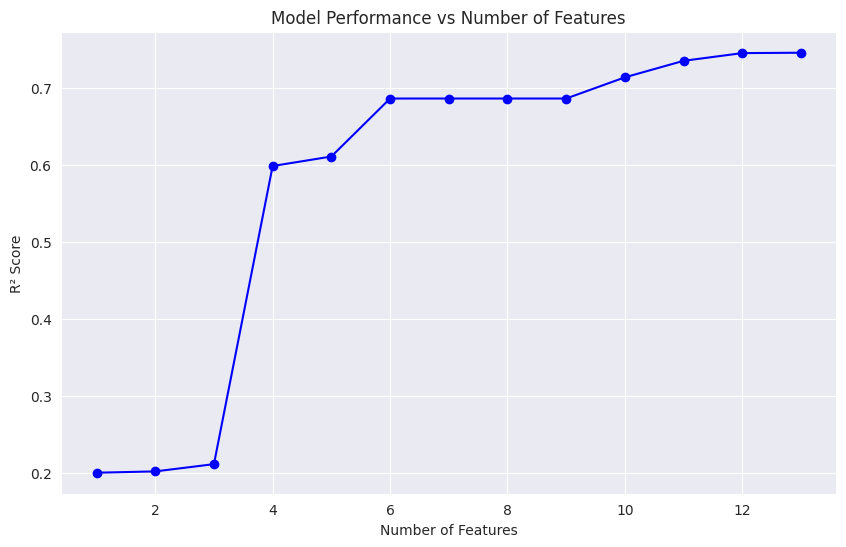

Optimal number of features: 13
Best score: 0.7460
Features selected: Index(['rm', 'ptratio', 'dis', 'nox', 'tax', 'lstat', 'crim', 'zn', 'indus',
       'age', 'rad', 'black', 'chas'],
      dtype='object')


In [9]:
def determine_optimal_number_of_features(X, y):
    feature_counts = range(1, X.shape[1] + 1)
    scores = []
    print(feature_counts)
    for num_features in feature_counts:
        model = LinearRegression()
        rfe = RFE(model, n_features_to_select = num_features)
        fit = rfe.fit(X, y)
        print("Num Features:", fit.n_features_)
        print("Selected Features:", fit.support_)
        print("Feature Ranking:", fit.ranking_)
        scores.append(rfe.score(X,y))
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, scores, 'b-', marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('R² Score')
    plt.title('Model Performance vs Number of Features')
    plt.grid(True)
    plt.show()
    best_num_features = feature_counts[argmax(scores)]
    print(f"Optimal number of features: {best_num_features}")
    print(f"Best score: {max(scores):.4f}")
    print(f"Features selected: {X.columns[fit.support_]}")
    return feature_counts, scores

feature_counts, scores = determine_optimal_number_of_features(X_train, y_train)

In [10]:
def determine_features_within_threshold(_feature_counts, _scores):
    best_score = max(_scores)
    best_score_index = argmax(_scores)
    threshold = best_score * 0.98
    best_num_features = _feature_counts[best_score_index]
    i = best_score_index
    for i in range(best_score_index, 0, -1):
        if _scores[i] < threshold:
            print(f"Lowest number of features within 1% of best score: {_feature_counts[i]}")
            break
print("Raw Data")
determine_features_within_threshold(feature_counts, scores)

Raw Data
Lowest number of features within 1% of best score: 10


In [11]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
        """ Perform a forward-backward feature selection
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(DataFrame(X[included+[new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, sm.add_constant(DataFrame(X[included]))).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

In [12]:
result = stepwise_selection(X_train, y_train)

Add  lstat                          with p-value 3.19774e-70
Add  rm                             with p-value 3.26237e-25
Add  ptratio                        with p-value 3.70851e-11
Add  black                          with p-value 1.28801e-05
Add  dis                            with p-value 2.99151e-06
Add  nox                            with p-value 1.0268e-05
Add  chas                           with p-value 0.000880151


## Build a multiple linear regression model using the RFE and the stepwise methods.

In [13]:
# Build a multiple linear regression model using the RFE and the stepwise methods.
# RFE
rfe_model = LinearRegression()
rfe = RFE(rfe_model, n_features_to_select=10)
fit = rfe.fit(X_train, y_train)
selected_columns = X_train.columns[fit.support_]
X_train_rfe = X_train[selected_columns]
rfe_model.fit(X_train_rfe, y_train)
print("Num Features:", fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

# Stepwise
step_model = LinearRegression()
# Build a model using the selected features in result
X_train_step = X_train[result]
step_model.fit(X_train_step, y_train)
print("Num Features:", len(result))
print("Selected Features:", result)
print("Feature Ranking:", [X_train.columns.get_loc(x) for x in result])

# Compare the two models across the training and test sets
def compare_models(model1, model2, X_test_rfe, X_test_step, y_test):
    # Calculate R² score for both models
    r2_score1 = model1.score(X_test_rfe, y_test)
    r2_score2 = model2.score(X_test_step, y_test)

    print(f"RFE Model R² Score: {r2_score1:.4f}")
    print(f"Stepwise Model R² Score: {r2_score2:.4f}")

# Prepare test data with the correct features for each model
X_test_rfe = X_test[selected_columns]  # Only use columns selected by RFE
X_test_step = X_test[result]           # Only use columns selected by stepwise

# Compare models with appropriate test data
compare_models(rfe_model, step_model, X_test_rfe, X_test_step, y_test)

Num Features: 10
Selected Features: [ True False  True False False  True  True  True  True  True  True  True
  True]
Feature Ranking: [1 2 1 3 4 1 1 1 1 1 1 1 1]
Num Features: 7
Selected Features: ['lstat', 'rm', 'ptratio', 'black', 'dis', 'nox', 'chas']
Feature Ranking: [5, 0, 1, 11, 2, 3, 12]
RFE Model R² Score: 0.5904
Stepwise Model R² Score: 0.6359


1. Use the Boston dataset and design a regression model using MLP regressor.

In [14]:
# Set random seeds for reproducibility
tf.keras.backend.clear_session()
random.seed(42)
tf.random.set_seed(42)
data = read_csv(filename)
data = data.drop('index', axis=1)
X = data.drop('medv', axis=1)
y = data['medv']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [15]:
# input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],))
# # #hidden1 = tf.keras.layers.Dense(64, activation="relu")(input_layer)
# hidden2 = tf.keras.layers.Dense(32, activation="relu", kernel_initializer='he_normal')(input_layer)#hidden1)
# # #hidden2 = tf.keras.layers.Dense(32, activation='selu', kernel_initializer='lecun_normal')(input_layer)
# output = tf.keras.layers.Dense(1)(hidden2)  # No activation for regression
# model = tf.keras.models.Model(inputs=[input_layer], outputs=[output])

# # # import SGD optimizer to use momentum
# # #sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# sgd = 'sgd'
# model.compile(
#     loss="mean_squared_error",
#     optimizer=sgd,
#     metrics=["mae"]
# )
# model.summary()

In [16]:
# history = model.fit(
#     X_train, y_train,
#     #epochs=100,  # Adjusted based on the later results and the output of 100 epochs showing diminishing returns
#     epochs=50,
#     validation_data=(X_valid, y_valid),
#     verbose=1
# )

In [17]:
configs = [
    {"layers": [32], "activation": "relu"},
    {"layers": [64], "activation": "relu"},
    {"layers": [32], "activation": "tanh"},
    {"layers": [64], "activation": "tanh"},
    {"layers": [32], "activation": "selu"},
    {"layers": [32], "activation": "sigmoid"},
]

results = []

for config in configs:
    print(f"Trying config: {config}")
    tf.keras.backend.clear_session()
    input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],))
    x = input_layer
    for units in config["layers"]:
        x = tf.keras.layers.Dense(units, activation=config["activation"])(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    # sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    sgd = 'sgd'
    model.compile(loss="mean_squared_error", optimizer=sgd, metrics=["mae"])
    model.summary()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_valid, y_valid),
        verbose=0
    )
    val_mae_hist = history.history["val_mae"]
    min_val_mae = np.min(val_mae_hist)
    best_epoch = np.argmin(val_mae_hist)
    best_loss = history.history["loss"][best_epoch]
    best_mae = history.history["mae"][best_epoch]
    best_val_loss = history.history["val_loss"][best_epoch]
    print(f"Best epoch: {best_epoch+1} | loss: {best_loss:.4f} - mae: {best_mae:.4f} - val_loss: {best_val_loss:.4f} - val_mae: {min_val_mae:.4f}")
    results.append({
        "config": config,
        "epoch": best_epoch+1,
        "loss": best_loss,
        "mae": best_mae,
        "val_loss": best_val_loss,
        "val_mae": min_val_mae,
        "history": history.history
    })

df_results = pd.DataFrame(results)
display(df_results)

Trying config: {'layers': [32], 'activation': 'relu'}


E0000 00:00:1746121461.201971  111834 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746121461.206984  111834 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

Best epoch: 46 | loss: 8.1227 - mae: 2.0843 - val_loss: 15.7844 - val_mae: 2.8913
Trying config: {'layers': [64], 'activation': 'relu'}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

Best epoch: 50 | loss: 6.9190 - mae: 1.9037 - val_loss: 14.2665 - val_mae: 2.6850
Trying config: {'layers': [32], 'activation': 'tanh'}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

Best epoch: 45 | loss: 6.3890 - mae: 1.8802 - val_loss: 28.5042 - val_mae: 3.1831
Trying config: {'layers': [64], 'activation': 'tanh'}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

Best epoch: 50 | loss: 6.8206 - mae: 1.9464 - val_loss: 26.3268 - val_mae: 3.3184
Trying config: {'layers': [32], 'activation': 'selu'}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

Best epoch: 32 | loss: 13.8969 - mae: 2.6924 - val_loss: 24.0677 - val_mae: 3.4049
Trying config: {'layers': [32], 'activation': 'sigmoid'}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

Best epoch: 50 | loss: 14.9808 - mae: 2.7878 - val_loss: 21.5035 - val_mae: 2.9753


,config,epoch,loss,mae,val_loss,val_mae,history
0,"{'layers': [32], 'activation': 'relu'}",46,8.122738,2.084343,15.784383,2.891272,"{'loss': [189.87046813964844, 24.0591888427734..."
1,"{'layers': [64], 'activation': 'relu'}",50,6.918999,1.903698,14.266532,2.684951,"{'loss': [182.2874298095703, 26.90657043457031..."
2,"{'layers': [32], 'activation': 'tanh'}",45,6.389031,1.880245,28.504171,3.183121,"{'loss': [308.91021728515625, 38.8237380981445..."
3,"{'layers': [64], 'activation': 'tanh'}",50,6.820627,1.946368,26.326763,3.318376,"{'loss': [285.0765075683594, 34.8847541809082,..."
4,"{'layers': [32], 'activation': 'selu'}",32,13.896895,2.692359,24.067738,3.404889,"{'loss': [239.81869506835938, 32.4827575683593..."
5,"{'layers': [32], 'activation': 'sigmoid'}",50,14.980777,2.787764,21.503498,2.975269,"{'loss': [224.00843811035156, 40.7017326354980..."


In [18]:
# Select the best configuration
best_idx = df_results["val_mae"].idxmin()
best_result = results[best_idx]
best_config = best_result["config"]
best_history = best_result["history"]

print(f"Best config: {best_config}")

Best config: {'layers': [64], 'activation': 'relu'}


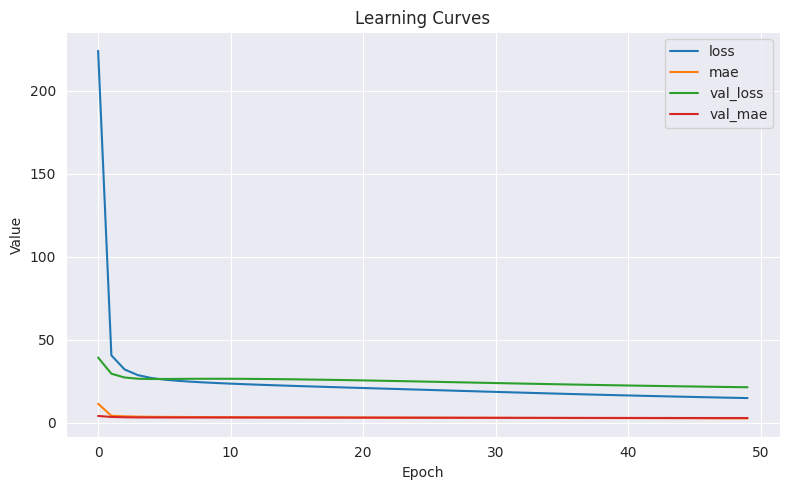

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.7500 - mae: 2.3646
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MLP Test MSE: 18.6580
MLP Test MAE: 2.6756
MLP Test R²: 0.7456
Linear Regression Test MSE: 25.1021
Linear Regression Test R²: 0.6577


In [19]:
# Plot learning curves
# DataFrame(history.history).plot(figsize=(8, 5))
DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Learning Curves")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test).flatten()
mlp_mse = mean_squared_error(y_test, y_pred)
mlp_r2 = r2_score(y_test, y_pred)

print(f"MLP Test MSE: {mlp_mse:.4f}")
print(f"MLP Test MAE: {test_mae:.4f}")
print(f"MLP Test R²: {mlp_r2:.4f}")

# Compare with Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Test MSE: {lr_mse:.4f}")
print(f"Linear Regression Test R²: {lr_r2:.4f}")

2. Compare the results with MLR model using cross validation. (rerun with MLR)

The MLP model outperforms the MLR model with cross validation in both lower test MSE and higher R² scores. This indicates that the MLP model with 64 units and ReLU activation has better generalization performance and prediction accuracy. The MLP's capacity to model complex, nonlinear relationships led to superior performance over the linear regression approach.

First layer weights shape: (13, 32)
First layer biases shape: (32,)


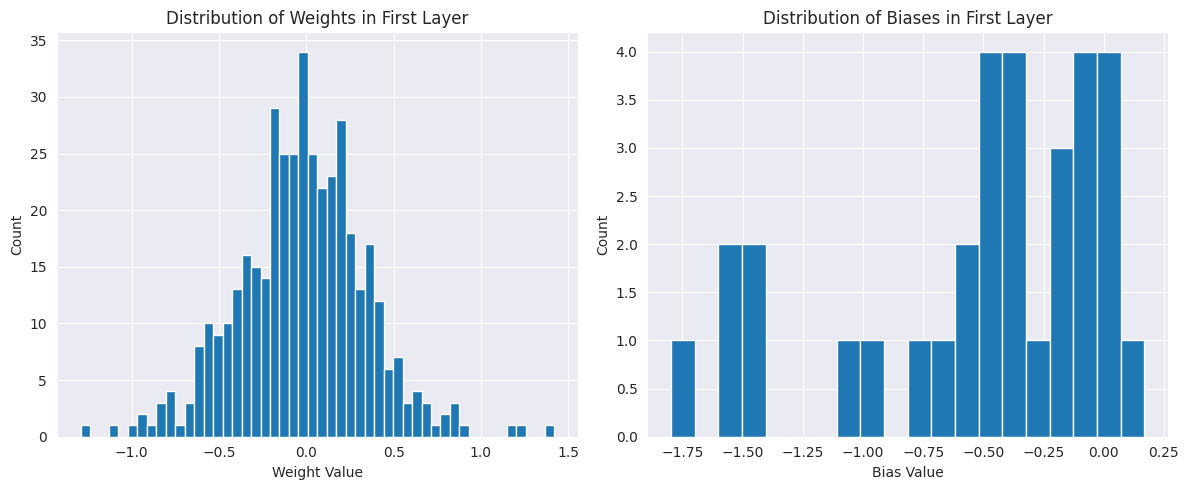

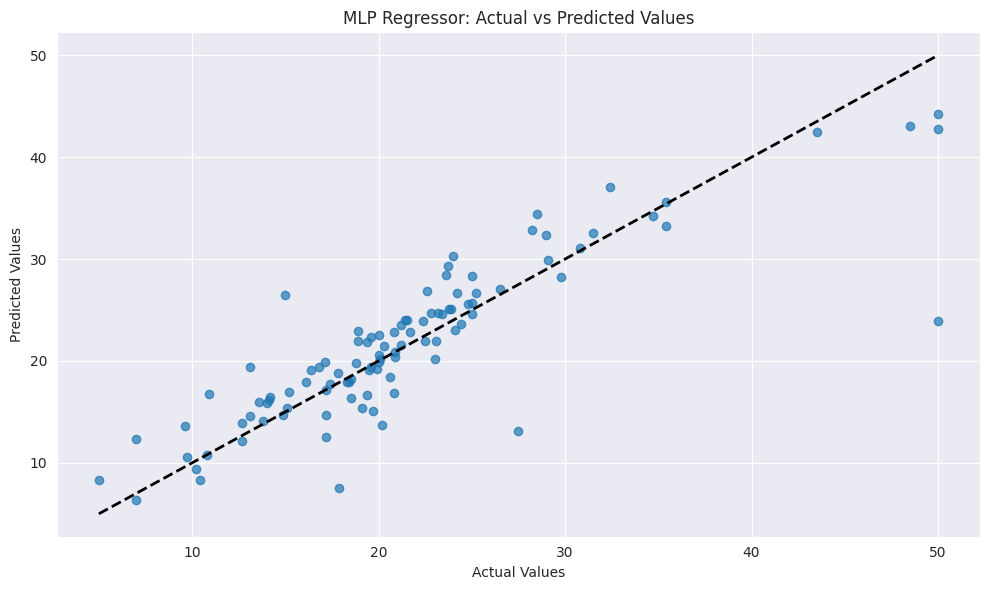

In [20]:
weights, biases = model.layers[1].get_weights()
print("First layer weights shape:", weights.shape)
print("First layer biases shape:", biases.shape)

# Plot the first few weights to visualize what the model learned
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weights.flatten(), bins=50)
plt.title("Distribution of Weights in First Layer")
plt.xlabel("Weight Value")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(biases, bins=20)
plt.title("Distribution of Biases in First Layer")
plt.xlabel("Bias Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("MLP Regressor: Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

3. Comment on the MLP regressor architecture and its relationship with overfitting.

The MLP regressor used here has a relatively simple architecture, consisting of an input layer, a single hidden dense layer (either 32 or 64 units), and an output layer. This simplicity is a key factor in preventing overfitting, as it limits the model's capacity to learn noise and patterns that do not generalize well to new data. The architecture also includes dropout regularization (0.1) to further prevent overfitting by randomly setting a fraction of input units to 0 during training.